In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import re 
from langdetect import detect
import tqdm
import glob
import os
from datetime import date, timedelta

In [2]:
pd.set_option('display.max_colwidth', 100)
pd.options.display.max_rows = 60
pd.options.display.max_colwidth = 300

ps = nltk.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

#### Functions

In [3]:
def input_tech(max_length_list = 5):
    """
    Input: User input with a part of or the entire technology as a string
    Return: A list of technologies the user is interested in    
    """
    tech = str(input("Enter technology: "))
    tech_list = []
    while (tech != "") & (len(tech_list) < max_length_list):
        tech_list.append(tech)
        tech = str(input("Enter technology: "))
    print(tech_list)
    return tech_list


def clean_text(text):
    """
    Input: Takes a sting from a DataFrame
    Return: a list of stemmed words, excluding punctuation and stopwords and the word html from the beginnnig of the string
    """
    text = text.lstrip('html ') # use to remove 'html' from begging of string; fixed in the scraper code
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopword]
    return text

def detect_language(text):
    """
    Input: Takes a string from a DataFrame
    Return: The dominant language in the string
    """
    language = detect(text)
    return language

### Load the data
_In case the positions are scraped in separated files concatenate the files_

In [4]:
jobs_data = pd.read_csv("it_jobs_20211710.csv")

#### Look ath the shape of the DataFrame and null values

In [5]:
print(jobs_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   position_id      6300 non-null   int64  
 1   position_url     6300 non-null   object 
 2   company_name     6300 non-null   object 
 3   position_views   6300 non-null   int64  
 4   job_description  6300 non-null   object 
 5   date_posted      6300 non-null   object 
 6   position_rating  3381 non-null   float64
 7   rating_color     3381 non-null   object 
 8   position         6300 non-null   object 
 9   benefits         6300 non-null   object 
 10  technologies     5364 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 541.5+ KB
None


## Brain Storming:
1. Technologies by companies
2. Technologies by Positions
3. Count of open positions by Company
4. Most viewed positions by companies
5. Most viewed positions 
6. Benefits from the Benefits column
7. Job posting by city

### 1. Technologies by Companies (Data cleaning + visualization)

In [6]:
# take only necessary columns
technology_company = jobs_data[['company_name', 'technologies']]
technology_company = technology_company.dropna(axis=0, how='any')

# transform the dataset
technology_company_expanded = technology_company['technologies'].str.split(',', expand=True) #split by commas
technology_company_expanded.columns = ['Technology'+str(i) for i in technology_company_expanded.columns] #set column headers
technology_company_concat = pd.concat([technology_company,technology_company_expanded], axis=1) # concatenate technology_company and technology_company_expanded
technology_company_concat.iloc[:,3:-1] = technology_company_concat.iloc[:,3:-1].apply(lambda x: x.str.strip()) #remove whitespaces from values in the columns
technology_in_company = pd.melt(technology_company_concat, id_vars=['company_name'], value_vars=technology_company_expanded.columns, var_name='Technology Number', value_name='Technology').dropna()

# groupby statement
technology_in_company = technology_in_company.groupby(['company_name', 'Technology']).count()
technology_in_company.sort_values(by=['company_name', 'Technology Number'], ascending=False, inplace=True)
technology_in_company.reset_index(inplace=True)
technology_in_company.head(15)

,company_name,Technology,Technology Number
0,флатексДЕГИРО - клон България,SQL,10
1,флатексДЕГИРО - клон България,Java,9
2,флатексДЕГИРО - клон България,Linux,9
3,флатексДЕГИРО - клон България,MySQL,7
4,флатексДЕГИРО - клон България,HTML/CSS,5
5,флатексДЕГИРО - клон България,Jenkins,5
6,флатексДЕГИРО - клон България,Jira,5
7,флатексДЕГИРО - клон България,Kafka,5
8,флатексДЕГИРО - клон България,ElasticSearch,4
9,флатексДЕГИРО - клон България,Nginx,4


In [12]:
tech_list = input_tech()

Enter technology:  golang
Enter technology:  


['golang']


In [13]:
filtered_technologies = pd.concat([technology_in_company[technology_in_company['Technology'].str.contains(tech, case=False, regex=False)] for tech in tech_list],ignore_index=True)
filtered_technologies

,company_name,Technology,Technology Number
0,Софтуер АГ Дивелъпмънт Център България ЕООД,Golang,1
1,Самап ЕООД,Golang,1
2,СЪРКЪЛС БЪЛГАРИЯ ЕООД,Golang,1
3,СТАНГА АД,Golang,1
4,СОФТСЪРВ БЪЛГАРИЯ ЕООД,Golang,4
...,...,...,...
59,BGStaffing EOOD,Golang,1
60,Alphatheta Music Bulgaria EOOD,Golang,1
61,Alcatraz Bulgaria EOOD,Golang,1
62,Acronis Bulgaria ЕOOD,Golang,1


In [14]:
companies_with_technologies = filtered_technologies.pivot(index='company_name', columns='Technology', values='Technology Number')
companies_with_technologies.sort_values(by='company_name', ascending=False, inplace=True)
companies_with_technologies.reset_index(inplace=True)
companies_with_technologies.set_index('company_name', inplace=True)
companies_with_technologies.dropna(axis=0, how='any', inplace=True)
companies_with_technologies

Technology,Golang
company_name,
Софтуер АГ Дивелъпмънт Център България ЕООД,1
Самап ЕООД,1
СЪРКЪЛС БЪЛГАРИЯ ЕООД,1
СТАНГА АД,1
СОФТСЪРВ БЪЛГАРИЯ ЕООД,4
...,...
BGStaffing EOOD,1
Alphatheta Music Bulgaria EOOD,1
Alcatraz Bulgaria EOOD,1


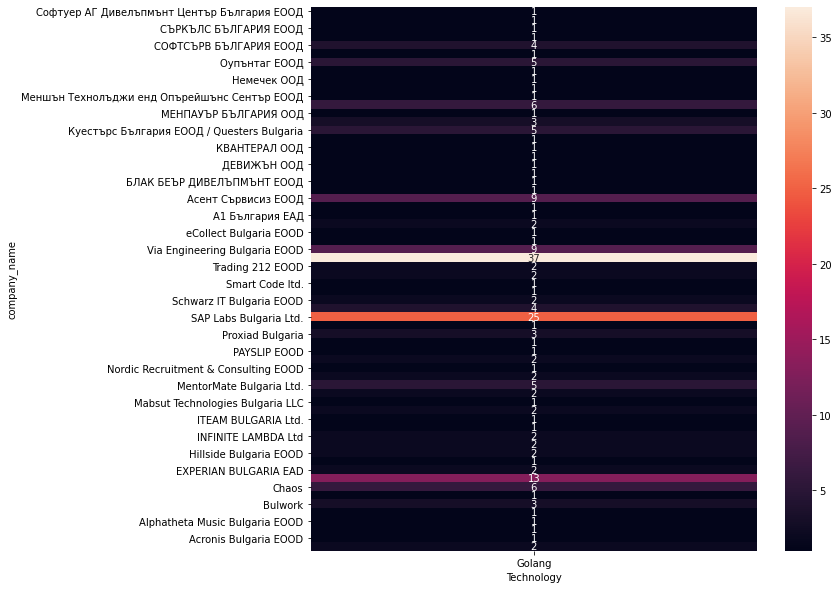

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(companies_with_technologies, annot=True)
plt.show()

### Clean the Description field + Stem it and Vectorize it

In [16]:
descriptions = jobs_data[['position_id', 'job_description','position','company_name']]
descriptions.head()

,position_id,job_description,position,company_name
0,5944384,html Customer Support Specialist with English Are you passionate about customer service? Are you looking for an organization where your career can develop rapidly within a short time frame? Do you want to gain global experience and move into an environment of IT support learning ...,Customer Support Specialist with English,ТЕК ЕКСПЪРТС ЕООД
1,5934985,html Customer Support Specialist with English and French Are you passionate about customer service? Are you looking for an organization where your career can develop rapidly within a short time frame? Do you want to gain global experience and move into an environment of IT support ...,Customer Support Specialist with English and French,ТЕК ЕКСПЪРТС ЕООД
2,5924446,html Service Desk Administrator with English and German Do you have strong troubleshooting skills? Do you love delivering exceptional customer service? Are you looking for a rapidly growing company to take your career to the next level? Tek Experts provides business and IT outsour...,Service Desk Administrator with English and German,ТЕК ЕКСПЪРТС ЕООД
3,5950538,"html Customer Support Representative Do you love delivering great customer service? Have you worked in an environment where you support subscription sales or bill payment processes? Tek Experts provides business and IT outsourcing services, and we take intense pride in helping co...",Customer Support Representative,ТЕК ЕКСПЪРТС ЕООД
4,5933745,"html Grafixoft is a leading software engineering company with a unique spirit. Our main aim and strength is the quality of our projects and services. Our relationships are based on honest communication, respect and the firm belief that everybody operates in accordance with the shared values....",Software Engineer (C#/.NET),ГРАФИКСОФТ ООД


In [17]:
descriptions = descriptions.copy()
descriptions['cleaned_text'] = descriptions['job_description'].apply(lambda x: clean_text(x.lower()))

In [18]:
descriptions.sample(5)

,position_id,job_description,position,company_name,cleaned_text
3494,5950155,"Оператор в зала за виртуална реалност \n\n\n\n\n\t\t\t\t\t\t \t\t\t\t\t\t \tВсички сме гледали филми за фантастичното бъдеще, ако искате да ги изживеете, станете част от нашия екип! \n\n\tБъдеще с високи технологии, множество реалности, бъдеще, където лимитът на въобра...",Оператор в зала за виртуална реалност,СЕЛЕСТИАЛ ООД,"[оператор, в, зала, за, виртуална, реалност, всички, сме, гледали, филми, за, фантастичното, бъдеще, ако, искате, да, ги, изживеете, станете, част, от, нашия, екип, бъдеще, с, високи, технологии, множество, реалности, бъдеще, където, лимитът, на, въображението, е, единствената, граница, е, бъдещ..."
249,5950075,"html What you will do? Responsible for technical design, coding, unit testing, technical documentation, and walkthroughs for all assigned SAP related projects to support company business and operational needs. Ensure software development follows the defined programming standards and follow...",SAP ABAP Consultant,MSG GLOBAL SOLUTIONS BULGARIA LTD.,"[respons, technic, design, code, unit, test, technic, document, walkthrough, assign, sap, relat, project, support, compani, busi, oper, need, ensur, softwar, develop, follow, defin, program, standard, follow, code, design, review, process, softwar, design, develop, packag, implement, use, sap, a..."
4553,5824507,html MISSIONS · Create effects and character animations · Prepare game interface · Tune overall game dynamics and rhythm REQUIREMENTS · Creativity and talent · Experience with 2D animation software NICE TO HAVE · Experience with graphic design software is a plus TECHNOLOGIES Normally w...,2D Animator,ДОПАМИН ЕООД,"[ission, creat, effect, charact, anim, prepar, game, interfac, tune, overal, game, dynam, rhythm, requir, creativ, talent, experi, 2d, anim, softwar, nice, experi, graphic, design, softwar, plu, technolog, normal, mix, technolog, look, right, combin, everi, project, far, prefer, project, spine, ..."
2620,5952421,html About us: Bulwork is the first IT recruitment agency in Bulgaria with more than 20 years of stable presence in the market. The company has established a reputation for delivering high-quality services both to clients and candidates. We respect the wishes of the candidates and s...,iOS Developer,Bulwork,"[us, bulwork, first, recruit, agenc, bulgaria, 20, year, stabl, presenc, market, compani, establish, reput, deliv, highqual, servic, client, candid, respect, wish, candid, strive, provid, best, servic, find, suitabl, challeng, job, client, global, supplier, system, softwar, onlin, gambl, compani..."
3853,5933560,Node.js Developer \n\n\n\n\n\t\t\t\t\t\t \t\t\t\t\t\t \t ### Node.js Developer\n\n Boom is where the change starts!\nWe’ve created the first competitive and gamified coding platform that is here t...,Node.js Developer,INTERNET ACADEMY EOOD,"[nodej, develop, nodej, develop, boom, chang, start, creat, first, competit, gamifi, code, platform, empow, next, gener, top, softwar, develop, interest, peopl, want, job, need, changer, develop, back, end, featur, web, applic, collabor, develop, solv, complex, problem, architectur, challeng, cu..."


In [19]:
descriptions['detected_language'] = descriptions['job_description'].apply(lambda x: detect_language(x))
descriptions.sample(5)

descriptions_engish = descriptions[descriptions['detected_language'] == 'en']
descriptions_engish = descriptions_engish[['position_id', 'job_description', 'position', 'company_name', 'cleaned_text']]
display(descriptions_engish.info())
display(descriptions_engish.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5697 entries, 0 to 6299
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   position_id      5697 non-null   int64 
 1   job_description  5697 non-null   object
 2   position         5697 non-null   object
 3   company_name     5697 non-null   object
 4   cleaned_text     5697 non-null   object
dtypes: int64(1), object(4)
memory usage: 267.0+ KB


None

,position_id,job_description,position,company_name,cleaned_text
0,5944384,html Customer Support Specialist with English Are you passionate about customer service? Are you looking for an organization where your career can develop rapidly within a short time frame? Do you want to gain global experience and move into an environment of IT support learning ...,Customer Support Specialist with English,ТЕК ЕКСПЪРТС ЕООД,"[custom, support, specialist, english, passion, custom, servic, look, organ, career, develop, rapidli, within, short, time, frame, want, gain, global, experi, move, environ, support, learn, new, technolog, custom, support, specialist, respons, provid, assist, queri, client, gather, inform, techn..."
1,5934985,html Customer Support Specialist with English and French Are you passionate about customer service? Are you looking for an organization where your career can develop rapidly within a short time frame? Do you want to gain global experience and move into an environment of IT support ...,Customer Support Specialist with English and French,ТЕК ЕКСПЪРТС ЕООД,"[custom, support, specialist, english, french, passion, custom, servic, look, organ, career, develop, rapidli, within, short, time, frame, want, gain, global, experi, move, environ, support, learn, new, technolog, custom, support, specialist, respons, provid, assist, queri, client, gather, infor..."
2,5924446,html Service Desk Administrator with English and German Do you have strong troubleshooting skills? Do you love delivering exceptional customer service? Are you looking for a rapidly growing company to take your career to the next level? Tek Experts provides business and IT outsour...,Service Desk Administrator with English and German,ТЕК ЕКСПЪРТС ЕООД,"[servic, desk, administr, english, german, strong, troubleshoot, skill, love, deliv, except, custom, servic, look, rapidli, grow, compani, take, career, next, level, tek, expert, provid, busi, outsourc, servic, take, intens, pride, help, compani, handl, busi, oper, due, expans, hire, servic, des..."
3,5950538,"html Customer Support Representative Do you love delivering great customer service? Have you worked in an environment where you support subscription sales or bill payment processes? Tek Experts provides business and IT outsourcing services, and we take intense pride in helping co...",Customer Support Representative,ТЕК ЕКСПЪРТС ЕООД,"[custom, support, repres, love, deliv, great, custom, servic, work, environ, support, subscript, sale, bill, payment, process, tek, expert, provid, busi, outsourc, servic, take, intens, pride, help, compani, handl, busi, oper, custom, face, support, engin, role, provid, phone, email, base, suppo..."
4,5933745,"html Grafixoft is a leading software engineering company with a unique spirit. Our main aim and strength is the quality of our projects and services. Our relationships are based on honest communication, respect and the firm belief that everybody operates in accordance with the shared values....",Software Engineer (C#/.NET),ГРАФИКСОФТ ООД,"[grafixoft, lead, softwar, engin, compani, uniqu, spirit, main, aim, strength, qualiti, project, servic, relationship, base, honest, commun, respect, firm, belief, everybodi, oper, accord, share, valu, respons, loyalti, hardwork, basi, behavior, part, develop, team, key, resourc, defin, solut, c..."


#### Vectorizing: Count Vectorization

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer=clean_text)
X_counts = count_vect.fit_transform(descriptions_engish['job_description'])
print(X_counts.shape)

(5697, 18855)


In [37]:
data_sample = descriptions_engish[0:20]

count_vect_sample = CountVectorizer(analyzer=clean_text)
X_counts_sample = count_vect_sample.fit_transform(data_sample['job_description'])
print(X_counts_sample.shape)

(20, 976)


In [38]:
X_counts_df = pd.DataFrame(X_counts_sample.toarray())
X_counts_df.columns = count_vect_sample.get_feature_names()
X_counts_df

,01,02,03,04,1,10,1000,10000,11,111417,...,year,yet,yoctobuild,you,young,your,zenzero,zuhlk,zühlke,а
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,2,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,2,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,3,0,0,0,1
6,1,1,1,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
7,0,0,0,0,0,1,0,0,0,1,...,0,1,1,1,0,2,0,1,0,0
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,2,0,0,1,0
9,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,2,0,0,1,0


#### Vectorizing: Count Vectorization (TF-IDF)

Creates a document-term matrix where the columns represent single unique terms (unigrams) but the cell represents a weighting meant to represent how important a word is to a document.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(descriptions_engish['job_description'])
print(X_tfidf.shape)

(5697, 18855)


In [40]:
data_sample = descriptions_engish[0:20]

tfidf_vect_sample = TfidfVectorizer(analyzer=clean_text)
X_tfidf_sample = tfidf_vect_sample.fit_transform(data_sample['job_description'])
print(X_tfidf_sample.shape)

(20, 976)


In [43]:
X_tfidf_df = pd.DataFrame(X_tfidf_sample.toarray())
X_tfidf_df.columns = tfidf_vect_sample.get_feature_names()
X_tfidf_df

,01,02,03,04,1,10,1000,10000,11,111417,...,year,yet,yoctobuild,you,young,your,zenzero,zuhlk,zühlke,а
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069154,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.068800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067934,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.067587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059842,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.029768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.065936,0.000000,0.054503,0.000000,0.000000,0.000000,...,0.050422,0.000000,0.000000,0.027112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.106863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.025847,0.000000,0.111510,0.000000,0.000000,0.000000,0.071513
6,0.081457,0.081457,0.081457,0.081457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.029442,0.071602,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.053562,0.000000,0.000000,0.000000,0.103049,...,0.000000,0.069269,0.103049,0.037246,0.000000,0.107123,0.000000,0.103049,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.071273,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142546,0.000000,0.000000,0.080403,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.076283,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.152566,0.000000,0.000000,0.086055,0.000000


In [140]:
from scipy.cluster.vq import kmeans

num_clusters = 10

cluster_centers, distortion = kmeans(X_tfidf_sample.todense(), num_clusters)
terms = tfidf_vect_sample.get_feature_names()
for i in range(num_clusters):
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:10])

['grafixoft', 'what', 'experi', 'offer', 'annual', 'grow', 'manag', 'engin', 'team', 'plu']
['sap', 'cloud', 'develop', 'team', 'work', 'experi', 'oper', 'technolog', 'employ', 'profession']
['project', 'manag', 'plan', 'stakehold', 'relev', 'scope', 'abl', 'initi', 'progress', 'budget']
['event', 'frontend', 'attende', 'fe', 'jqueri', 'develop', 'react', 'ui', 'lead', 'market']
['experi', 'retail', 'frontend', 'platform', 'least', 'basic', 'appoint', 'onlin', 'month', 'vacanc']
['game', 'experi', 'develop', 'abl', 'be', 'park', 'space', 'specif', 'skill', 'offic']
['insur', 'consid', 'adf', 'fadata', 'oracl', 'growth', 'would', 'objectori', 'develop', 'advantag']
['qa', 'work', 'experian', 'custom', 'inform', 'test', 'manag', 'credit', 'technic', 'balanc']
['develop', 'work', 'applic', 'code', 'experi', 'softwar', 'team', 'design', 'familiar', 'android']
['you', 'squad', 'product', 'secur', 'design', 'work', 'via', 'prioritis', 'partner', 'experi']


#### Vectorizing: TF-IDF - Dimensionality Reduction

In [96]:
data_sample = descriptions_engish[0:1000]

tfidf = TfidfVectorizer(analyzer=clean_text)
csr_matrix = tfidf.fit_transform(descriptions_engish['job_description'])

words = tfidf.get_feature_names()

#print(csr_matrix.toarray())
#print(words)


## PCA

In [106]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

pca_matrix = pd.DataFrame(csr_matrix.toarray())

# Create a PCA instace: pca
pca = PCA(n_components=1000)
#pca.fit(csr_mat_mat)

# Create a KMeans instance: kmeans
kmeans = KMeans(n_clusters=2)

# Create a pipeline: pipeline
pipeline = make_pipeline(pca, kmeans)

# Fit the pipeline to words
pipeline.fit(pca_matrix)

# Calculate the cluster labels: labels
labels = pipeline.predict(pca_matrix)

# Create a DataFrame aligning labels and titles: df
#df = pd.DataFrame({'label': labels, 'position': list(descriptions_engish.position), 'position id': list(descriptions_engish['position_id']), 'company': list(descriptions_engish['company_name'])})
pca_df = pd.DataFrame({'label': labels, 'position': list(descriptions_engish.position), 'position id': list(descriptions_engish['position_id']), 'company': list(descriptions_engish['company_name'])})



# Display df sorted by cluster label
#print(df.sort_values('label'))
print(np.sum(pca.explained_variance_ratio_))

0.8097906554572564


In [70]:
lst =[]
for i in tqdm.tqdm(range(1,5)):
    km = KMeans(n_clusters=i)
    km.fit(pca_matrix)
    lst.append(km.inertia_)


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


#### TruncatedSVD

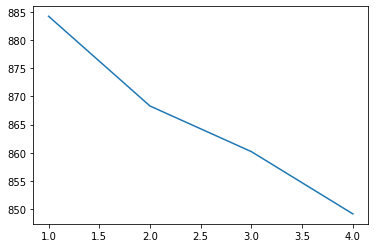

In [72]:
plt.plot(range(1,5),lst)
plt.show()

## TruncatedSVD

In [75]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

svd_matrix = pd.DataFrame(csr_matrix.toarray())

# Create a TruncatedSVD instace: svd
svd = TruncatedSVD(n_components=300)

# Create a KMeans instance: kmeans
kmeans = KMeans(n_clusters=20)

# Create a pipeline: pipeline
pipeline = make_pipeline(svd, kmeans)

# Fit the pipeline to words
pipeline.fit(svd_matrix)

# Calculate the cluster labels: labels
labels = pipeline.predict(svd_matrix)

# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({'label': labels, 'position': list(data_sample.position), 'position id': list(data_sample['position_id']), 'company': list(data_sample['company_name'])})

# Display df sorted by cluster label
#print(df.sort_values('label'))

In [336]:
svd.explained_variance_ratio_

array([0.00522373, 0.01834596, 0.01551494, 0.0106122 , 0.00971697,
       0.00908739, 0.00833544, 0.0077819 , 0.00749662, 0.00719101,
       0.00632372, 0.00593077, 0.0055282 , 0.00522877, 0.00519182,
       0.00497155, 0.00490438, 0.00482402, 0.00469419, 0.00451425,
       0.00438518, 0.00421835, 0.00415703, 0.00403604, 0.00393345,
       0.00384441, 0.00377838, 0.00368713, 0.00366862, 0.0036152 ,
       0.00356139, 0.00342807, 0.00342436, 0.00335535, 0.00331986,
       0.00330095, 0.00327764, 0.00322823, 0.00319181, 0.00311446,
       0.00306723, 0.00303906, 0.00298171, 0.00294275, 0.00285133,
       0.00282657, 0.00280709, 0.00276563, 0.00272866, 0.00270938,
       0.00268996, 0.00263809, 0.00260377, 0.00259444, 0.00255787,
       0.00251196, 0.0024719 , 0.00246641, 0.00244754, 0.00241232,
       0.00238559, 0.00237471, 0.00232635, 0.00230595, 0.00227396,
       0.00225752, 0.00223278, 0.00221031, 0.0021789 , 0.00216213,
       0.00212999, 0.00211332, 0.00208261, 0.00207983, 0.00206

In [ ]:
lst =[]
for i in tqdm.tqdm(range(1,5)):
    km = KMeans(n_clusters=i)
    km.fit(pca_matrix)
    lst.append(km.inertia_)

In [ ]:
plt.plot(range(1,5),lst)
plt.show()

In [86]:
pd.options.display.max_rows=1350

In [112]:
cluster_n = pca_df[pca_df['label']==0]
cluster_n = cluster_n.copy()
cluster_n.sort_values(by='company', ascending=False, inplace=True)
display(cluster_n.shape)
display(cluster_n.company.value_counts().head(10))
display(cluster_n.head(50))

(177, 4)

VMware Bulgaria    177
Name: company, dtype: int64

,label,position,position id,company
1223,0,Graphic Designer,5950916,VMware Bulgaria
4900,0,Senior Financial Analyst,5864710,VMware Bulgaria
5633,0,Senior Cloud Automation Developer - Opportunity for Working Remotely,5805616,VMware Bulgaria
5634,0,Software Engineer with Python - ESXi Lifecycle - Opportunity for Working Remotely,5805644,VMware Bulgaria
5635,0,"Senior Android Engineer, Boxer team - Opportunity for Working Remotely",5805582,VMware Bulgaria
5636,0,"Site Reliability Engineer, VMware Carbon Black - Opportunity for Working Remotely",5805670,VMware Bulgaria
5637,0,"Lead Cloud Automation Developer, PS CoE - Opportunity for Working Remotely",5805761,VMware Bulgaria
5638,0,Lead Cloud Automation Developer/Team Lead - Opportunity for Working Remotely,5805624,VMware Bulgaria
5639,0,"Infrastructure Software Engineer, Cloud Management",5805726,VMware Bulgaria
5640,0,"Junior Full Stack Developer, Cloud Management",5805777,VMware Bulgaria


In [111]:
pos_count_vect = CountVectorizer(analyzer=clean_text)
pos_title_count = pos_count_vect.fit_transform(cluster_n.position)
pos_df = pd.DataFrame(pos_title_count.toarray())
pos_df.columns = pos_count_vect.get_feature_names()
pos_df.sum(axis=0).sort_values(ascending=False)

develop                          1819
engin                            1428
senior                           1021
softwar                           526
manag                             411
support                           392
specialist                        381
java                              360
qa                                311
technic                           291
data                              266
analyst                           264
junior                            255
administr                         243
net                               241
devop                             225
system                            221
frontend                          213
autom                             208
english                           193
cloud                             171
busi                              162
it                                159
lead                              157
servic                            148
full                              148
project     

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265
1500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
accept,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
analyst,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
analystautom,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
api,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
appium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
applic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
architect,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
assur,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
atida,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
